In [1]:
import h5py    
import numpy as np  
import pandas as pd
from pylab import savefig
from sklearn.ensemble import IsolationForest
from pylab import *
import pandas as pd
import numpy as np

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

import sklearn.svm as ssvm


from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

import pywt
from pywt import wavedec
import scipy.stats as stats
from statsmodels.robust import mad

In [2]:
f= pd.read_hdf('train.hdf5')
v=pd.read_hdf('validation.hdf5')

In [3]:
f=pd.DataFrame(f)
v=pd.DataFrame(v)

In [4]:
test=pd.read_hdf('test.hdf5')
test=pd.DataFrame(test)

In [5]:
def get_true_anom():
    data = 0x1323b136220e15dd4d1ff9681fa066ada681fc081ddd4c61e1c0fd118121ee524ca9286fc08bf58c64128c557cc8bc73212e3eec926452fbc7d9d9ace6eb98f9b381c8fbdd5d24743fd59
    res = list(map(lambda x: x == '1', bin(data)[2:]))
    return [False]*(594-len(res)) + res

In [6]:
#reponse=pd.read_excel('reponseEmmeline.xlsx')
reponse=get_true_anom()

In [7]:
sum(reponse)

297

In [8]:
all_data=pd.concat([f,v],axis=0)
all_data=all_data.reset_index()
all_data=all_data.drop(columns='index')

In [9]:
wf = "haar"

Coeff = []
TCoeff = []
for i in range(2271) :
    #Apply wavelet decomposition
    x=all_data.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(2271, 61441) (2271, 61441)
137162577 15870780


In [10]:
len(Coeff)

2271

In [11]:
Coeff1=Coeff[:1677,:]
Coeff2=Coeff[1677:,:]

TCoeff1=TCoeff[:1677,:]
TCoeff2=TCoeff[1677:,:]

In [12]:
def test_result(liste,vrai=reponse):
    num=0
    for i in range(594):
        if vrai[i]==liste[i]:
            num+=1
    return num/594

In [13]:
   
def scores(liste,vrai=reponse):
    anomalies=[1 if i in liste else 0 for i in range(594)]
    precision= len(np.intersect1d(liste,np.where(vrai)))/len(liste)
    #print(np.where(anomalies==1))
    #print(precision)
    recall= len(np.intersect1d(liste,np.where(vrai)))/len(np.where(vrai)[0])
    #print(recall)
    f1score= 2*((precision*recall)/(precision+recall))
    print('f1score :', f1score, ' ; precision : ',precision , ' ; recall : ',recall)

In [14]:
import sklearn.svm as ssvm
def detection_anomaly(acp,acp2):
    OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

    fitter1=OCS.fit(acp)
    anoSVM = fitter1.predict(acp2)

    for i in range(len(anoSVM)) : 
        if anoSVM[i]==1 : 
            anoSVM[i]=0
        else :
            anoSVM[i]= 1 
    print("nombre d'anomalies trouvées par SVM",sum(anoSVM))

    contamination=0.5
    metric = "euclidean"
    clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric,novelty=True)
    fitter2 = clf.fit(acp)
    anoLOF=fitter2.predict(acp2)

    for i in range(len(anoLOF)) : 
        if anoLOF[i]==1 : 
            anoLOF[i]=0
        else :
            anoLOF[i]= 1 
    
    print("nombre d'anomalies trouvées par LOF",sum(anoLOF))

    clf = IsolationForest(behaviour='new',contamination=0.5)
    fitter3=clf.fit(acp)
    anoISO=fitter3.predict(acp2)

    for i in range(len(anoISO)) : 
        if anoISO[i]==1 : 
            anoISO[i]=0
        else :
            anoISO[i]= 1 
    print("nombre d'anomalies trouvées par Isolation Forest",sum(anoISO))
    
    listoutliersintersect=np.intersect1d(np.where(anoLOF==1),np.where(anoSVM==1),np.where(anoISO==1))
    listoutliersunion=np.union1d(np.union1d(np.where(anoLOF==1),np.where(anoSVM==1)),np.where(anoISO==1))
    print('scores Isolation Forest')
    scores(np.where(anoISO==1)[0])
    print('scores SVM')
    scores(np.where(anoSVM==1)[0])
    print('scores LOF')
    scores(np.where(anoLOF==1)[0])
    print('scores union des techniques')
    scores(listoutliersunion)
    print('scores intersection des techniques')
    scores(listoutliersintersect)
    listoutliersintersect1=np.intersect1d(np.where(anoLOF==1),np.where(anoSVM==1))
    print('scores intersection SVM LOF')
    scores(listoutliersintersect1)
    listoutliersintersect2=np.intersect1d(np.where(anoLOF==1),np.where(anoISO==1))
    print('scores intersection Isolation Forest LOF')
    scores(listoutliersintersect2) 
    listoutliersintersect3=np.intersect1d(np.where(anoISO==1),np.where(anoSVM==1))
    print('scores intersection SVM Isolation Forest')
    scores(listoutliersintersect3)
    listoutliersunion1=np.union1d(np.where(anoLOF==1),np.where(anoSVM==1))
    print('scores union SVM LOF')
    scores(listoutliersunion1)
    listoutliersunion2=np.union1d(np.where(anoLOF==1),np.where(anoISO==1))
    print('scores union Isolation Forest LOF')
    scores(listoutliersunion2) 
    listoutliersunion3=np.union1d(np.where(anoISO==1),np.where(anoSVM==1))
    print('scores union SVM Isolation Forest')
    scores(listoutliersunion3)
    return anoSVM,anoLOF,anoISO


In [15]:
anoSVM,anoLOF,anoISO=detection_anomaly(Coeff[:1677,:1024],Coeff[1677:,:1024])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 261
nombre d'anomalies trouvées par LOF 321
nombre d'anomalies trouvées par Isolation Forest 292
scores Isolation Forest
f1score : 0.5840407470288624  ; precision :  0.589041095890411  ; recall :  0.5791245791245792
scores SVM
f1score : 0.9247311827956989  ; precision :  0.9885057471264368  ; recall :  0.8686868686868687
scores LOF
f1score : 0.7411003236245954  ; precision :  0.7133956386292835  ; recall :  0.7710437710437711
scores union des techniques
f1score : 0.7337110481586401  ; precision :  0.6332518337408313  ; recall :  0.8720538720538721
scores intersection des techniques
f1score : 0.870722433460076  ; precision :  1.0  ; recall :  0.7710437710437711
scores intersection SVM LOF
f1score : 0.870722433460076  ; precision :  1.0  ; recall :  0.7710437710437711
scores intersection Isolation Forest LOF
f1score : 0.5697211155378485  ; precision :  0.697560975609756  ; recall :  0.48148148148148145
scores intersection SVM Isolation Forest
f1score :

In [16]:
test_result(anoSVM)

0.9292929292929293

In [17]:
all_data_smooth=all_data.ewm(alpha=0.3).mean()

In [18]:
wf = "haar"

Coeff_smooth = []
TCoeff_smooth = []
for i in range(2271) :
    print(i)
    #Apply wavelet decomposition
    x=all_data_smooth.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff_smooth.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff_smooth.append(coeffs_thresh_flatten)
    
Coeff_smooth = np.array(Coeff_smooth)
TCoeff_smooth = np.array(TCoeff_smooth)
print(Coeff_smooth.shape, TCoeff_smooth.shape)
print(np.sum(Coeff_smooth!=0), np.sum(TCoeff_smooth!=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068


In [19]:
anoSVM,anoLOF,anoISO=detection_anomaly(Coeff_smooth[:1677,512:2048],Coeff_smooth[1677:,512:2048])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 125
nombre d'anomalies trouvées par LOF 565
nombre d'anomalies trouvées par Isolation Forest 364
scores Isolation Forest
f1score : 0.6293494704992435  ; precision :  0.5714285714285714  ; recall :  0.7003367003367004
scores SVM
f1score : 0.4312796208530805  ; precision :  0.728  ; recall :  0.3063973063973064
scores LOF
f1score : 0.6566125290023203  ; precision :  0.5008849557522124  ; recall :  0.9528619528619529
scores union des techniques
f1score : 0.6528258362168397  ; precision :  0.4964912280701754  ; recall :  0.9528619528619529
scores intersection des techniques
f1score : 0.4312796208530805  ; precision :  0.728  ; recall :  0.3063973063973064
scores intersection SVM LOF
f1score : 0.4312796208530805  ; precision :  0.728  ; recall :  0.3063973063973064
scores intersection Isolation Forest LOF
f1score : 0.6341463414634146  ; precision :  0.5793871866295265  ; recall :  0.7003367003367004
scores intersection SVM Isolation Forest
f1score : 0.431

anoSVM,anoLOF,anoISO=detection_anomaly(fftCoeff[:1677,:],fftCoeff[1677:,:])

# Feature Engeneering


In [20]:

features= np.zeros((2271,21))
for i in range(2271) : 
    features[i,0] = np.mean(Coeff[i,:1024])
    features[i,1] = np.var(Coeff[i,:1024])
    features[i,2] = np.median(Coeff[i,:1024])
    features[i,3] = np.real(stats.kurtosis(Coeff[i,:1024],bias=False))
    features[i,4] = np.real(stats.skew(Coeff[i,:1024],bias=False))
    features[i,5] = np.min(Coeff[i,:1024])
    features[i,6] = np.max(Coeff[i,:1024])   
    features[i,7] = np.mean(TCoeff[i,:1024])
    features[i,8] = np.var(TCoeff[i,:1024])
    features[i,9] = np.median(TCoeff[i,:1024])
    features[i,10] = np.real(stats.kurtosis(TCoeff[i,:1024],bias=False))
    features[i,11] = np.real(stats.skew(TCoeff[i,:1024],bias=False))
    features[i,12] = np.min(TCoeff[i,:1024])
    features[i,13] = np.max(TCoeff[i,:1024]) 
    features[i,14] = np.min(all_data.iloc[i])
    features[i,15] = np.max(all_data.iloc[i])    
    features[i,16] = np.mean(all_data.iloc[i])
    features[i,17] = np.var(all_data.iloc[i])
    features[i,18] = np.median(all_data.iloc[i])
    features[i,19] = np.real(stats.kurtosis(all_data.iloc[i],bias=False))
    features[i,20] = np.real(stats.skew(all_data.iloc[i],bias=False))
    
    #features[i,10]=np.mean(fftCoeff[i])
    #features[i,11] = np.var(fftCoeff[i])
    #features[i,12] = np.median(fftCoeff[i])
    #features[i,13] = np.real(stats.kurtosis(fftCoeff[i],bias=False))
    #features[i,14] = np.real(stats.skew(fftCoeff[i],bias=False))    
    

In [135]:
anoSVM_features_all_data,anoLOF,anoISO=detection_anomaly(features[:1677,[14,15,18]],features[1677:,[14,15,18]])
#meilleure pour le moment

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 281
nombre d'anomalies trouvées par LOF 442
nombre d'anomalies trouvées par Isolation Forest 392
scores Isolation Forest
f1score : 0.8592162554426704  ; precision :  0.7551020408163265  ; recall :  0.9966329966329966
scores SVM
f1score : 0.9619377162629758  ; precision :  0.9893238434163701  ; recall :  0.936026936026936
scores LOF
f1score : 0.7794316644113668  ; precision :  0.6515837104072398  ; recall :  0.9696969696969697
scores union des techniques
f1score : 0.7754569190600521  ; precision :  0.6332622601279317  ; recall :  1.0
scores intersection des techniques
f1score : 0.9618055555555556  ; precision :  0.992831541218638  ; recall :  0.9326599326599326
scores intersection SVM LOF
f1score : 0.9618055555555556  ; precision :  0.992831541218638  ; recall :  0.9326599326599326
scores intersection Isolation Forest LOF
f1score : 0.8670694864048338  ; precision :  0.7863013698630137  ; recall :  0.9663299663299664
scores intersection SVM Isolation F

In [22]:
anoSVM,anoLOF,anoISO=detection_anomaly(features[:1677,[9,12,13]],features[1677:,[9,12,13]])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 310
nombre d'anomalies trouvées par LOF 474
nombre d'anomalies trouvées par Isolation Forest 390
scores Isolation Forest
f1score : 0.8034934497816595  ; precision :  0.7076923076923077  ; recall :  0.9292929292929293
scores SVM
f1score : 0.8830313014827017  ; precision :  0.864516129032258  ; recall :  0.9023569023569024
scores LOF
f1score : 0.7341115434500649  ; precision :  0.5970464135021097  ; recall :  0.9528619528619529
scores union des techniques
f1score : 0.7183271832718326  ; precision :  0.5658914728682171  ; recall :  0.9831649831649831
scores intersection des techniques
f1score : 0.8762541806020068  ; precision :  0.8704318936877077  ; recall :  0.8821548821548821
scores intersection SVM LOF
f1score : 0.8762541806020068  ; precision :  0.8704318936877077  ; recall :  0.8821548821548821
scores intersection Isolation Forest LOF
f1score : 0.8297213622291022  ; precision :  0.7679083094555874  ; recall :  0.9023569023569024
scores intersectio

In [23]:
all_data_centered=all_data.apply(lambda row: (row-np.mean(row))/np.var(row))

In [24]:
wf = "haar"

Coeff_centered = []
TCoeff_centered = []
for i in range(2271) :
    #Apply wavelet decomposition
    x=all_data_centered.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff_centered.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff_centered.append(coeffs_thresh_flatten)
    
Coeff_centered  = np.array(Coeff_centered )
TCoeff_centered  = np.array(TCoeff_centered )
print(Coeff_centered .shape, TCoeff_centered .shape)
print(np.sum(Coeff_centered !=0), np.sum(TCoeff_centered !=0))

(2271, 61441) (2271, 61441)
139530240 15582227


In [25]:
anoSVM_coeff_centered,anoLOF,anoISO=detection_anomaly(Coeff_centered [:1677,:1024],Coeff_centered [1677:,:1024])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 262
nombre d'anomalies trouvées par LOF 320
nombre d'anomalies trouvées par Isolation Forest 341
scores Isolation Forest
f1score : 0.7021943573667712  ; precision :  0.656891495601173  ; recall :  0.7542087542087542
scores SVM
f1score : 0.9373881932021467  ; precision :  1.0  ; recall :  0.8821548821548821
scores LOF
f1score : 0.7423014586709887  ; precision :  0.715625  ; recall :  0.7710437710437711
scores union des techniques
f1score : 0.7460992907801418  ; precision :  0.6446078431372549  ; recall :  0.8855218855218855
scores intersection des techniques
f1score : 0.8685714285714284  ; precision :  1.0  ; recall :  0.7676767676767676
scores intersection SVM LOF
f1score : 0.8685714285714284  ; precision :  1.0  ; recall :  0.7676767676767676
scores intersection Isolation Forest LOF
f1score : 0.6980108499095842  ; precision :  0.75390625  ; recall :  0.6498316498316499
scores intersection SVM Isolation Forest
f1score : 0.8576923076923078  ; precisio

In [26]:
features_centered= np.zeros((2271,21))
for i in range(2271) : 
    features_centered[i,0] = np.mean(all_data_centered.iloc[i])
    features_centered[i,1] = np.var(all_data_centered.iloc[i])
    features_centered[i,2] = np.median(all_data_centered.iloc[i])
    features_centered[i,3] = np.real(stats.kurtosis(all_data_centered.iloc[i],bias=False))
    features_centered[i,4] = np.real(stats.skew(all_data_centered.iloc[i],bias=False))
    features_centered[i,5] = np.min(all_data_centered.iloc[i])
    features_centered[i,6] = np.max(all_data_centered.iloc[i])
    features_centered[i,7] = np.mean(Coeff_centered[i,:1024])
    features_centered[i,8] = np.var(Coeff_centered[i,:1024])
    features_centered[i,9] = np.median(Coeff_centered[i,:1024])
    features_centered[i,10] = np.real(stats.kurtosis(Coeff_centered[i,:1024],bias=False))
    features_centered[i,11] = np.real(stats.skew(Coeff_centered[i,:1024],bias=False))
    features_centered[i,12] = np.min(Coeff_centered[i,:1024])
    features_centered[i,13] = np.max(Coeff_centered[i,:1024])
    features_centered[i,14] = np.mean(TCoeff_centered[i,:1024])
    features_centered[i,15] = np.var(TCoeff_centered[i,:1024])
    features_centered[i,16] = np.median(TCoeff_centered[i,:1024])
    features_centered[i,17] = np.real(stats.kurtosis(TCoeff_centered[i,:1024],bias=False))
    features_centered[i,18] = np.real(stats.skew(TCoeff_centered[i,:1024],bias=False))
    features_centered[i,19] = np.min(TCoeff_centered[i,:1024])
    features_centered[i,20] = np.max(TCoeff_centered[i,:1024])


In [27]:
anoSVM,anoLOF,anoISO=detection_anomaly(features_centered [:1677,[7,9]],features_centered [1677:,[7,9]])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 258
nombre d'anomalies trouvées par LOF 444
nombre d'anomalies trouvées par Isolation Forest 376
scores Isolation Forest
f1score : 0.787518573551263  ; precision :  0.7047872340425532  ; recall :  0.8922558922558923
scores SVM
f1score : 0.9297297297297298  ; precision :  1.0  ; recall :  0.8686868686868687
scores LOF
f1score : 0.7395411605937922  ; precision :  0.6171171171171171  ; recall :  0.9225589225589226
scores union des techniques
f1score : 0.7128463476070528  ; precision :  0.5694164989939637  ; recall :  0.9528619528619529
scores intersection des techniques
f1score : 0.916058394160584  ; precision :  1.0  ; recall :  0.8451178451178452
scores intersection SVM LOF
f1score : 0.916058394160584  ; precision :  1.0  ; recall :  0.8451178451178452
scores intersection Isolation Forest LOF
f1score : 0.8258064516129032  ; precision :  0.7925696594427245  ; recall :  0.8619528619528619
scores intersection SVM Isolation Forest
f1score : 0.929729729729

# Test

In [28]:
wf = "haar"

Coeff_test = []
TCoeff_test = []
for i in range(1917) :
    #Apply wavelet decomposition
    x=test.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff_test.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff_test.append(coeffs_thresh_flatten)
    
Coeff_test  = np.array(Coeff_test )
TCoeff_test  = np.array(TCoeff_test )
print(Coeff_test .shape, TCoeff_test .shape)
print(np.sum(Coeff_test !=0), np.sum(TCoeff_test !=0))

(1917, 61441) (1917, 61441)
117016632 16262054


In [29]:
features_test= np.zeros((1917,22))
for i in range(1917) :
    features_test[i,0] = np.min(test.iloc[i])
    features_test[i,1] = np.max(test.iloc[i])    
    features_test[i,2] = np.median(test.iloc[i])
    features_test[i,3] = np.mean(test.iloc[i])
    features_test[i,4] = np.var(test.iloc[i])
    features_test[i,5] = np.median(test.iloc[i])
    features_test[i,6] = np.real(stats.kurtosis(test.iloc[i],bias=False))
    features_test[i,7] = np.real(stats.skew(test.iloc[i],bias=False))
    features_test[i,10] = np.mean(Coeff_test[i,:1024])
    features_test[i,11] = np.var(Coeff_test[i,:1024])
    features_test[i,12] = np.median(Coeff_test[i,:1024])
    features_test[i,13] = np.real(stats.kurtosis(Coeff_test[i,:1024],bias=False))
    features_test[i,14] = np.real(stats.skew(Coeff_test[i,:1024],bias=False))
    features_test[i,15] = np.min(Coeff_test[i,:1024])
    features_test[i,16] = np.max(Coeff_test[i,:1024])
    features_test[i,17] = np.mean(TCoeff_test[i,:1024])
    features_test[i,18] = np.var(TCoeff_test[i,:1024])
    features_test[i,19] = np.median(TCoeff_test[i,:1024])
    features_test[i,20] = np.real(stats.kurtosis(TCoeff_test[i,:1024],bias=False))
    features_test[i,21] = np.real(stats.skew(TCoeff_test[i,:1024],bias=False))
    features_test[i,8] = np.min(TCoeff_test[i,:1024])
    features_test[i,9] = np.max(TCoeff_test[i,:1024])

In [139]:
anoSVM_coeff_test,anoLOF_coeff_test,anoISO_coeff_test=detection_anomaly(Coeff[:1677,:1024],Coeff_test[:,:1024])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 245
nombre d'anomalies trouvées par LOF 1000
nombre d'anomalies trouvées par Isolation Forest 692
scores Isolation Forest
f1score : 0.20424671385237614  ; precision :  0.14595375722543352  ; recall :  0.3400673400673401
scores SVM
f1score : 0.14022140221402216  ; precision :  0.15510204081632653  ; recall :  0.12794612794612795
scores LOF
f1score : 0.2390131071703932  ; precision :  0.155  ; recall :  0.5218855218855218
scores union des techniques
f1score : 0.23981552651806304  ; precision :  0.1553784860557769  ; recall :  0.5252525252525253
scores intersection des techniques
f1score : 0.1367837338262477  ; precision :  0.15163934426229508  ; recall :  0.12457912457912458
scores intersection SVM LOF
f1score : 0.1367837338262477  ; precision :  0.15163934426229508  ; recall :  0.12457912457912458
scores intersection Isolation Forest LOF
f1score : 0.20304568527918782  ; precision :  0.14534883720930233  ; recall :  0.3367003367003367
scores intersecti

In [160]:
anoSVM_coeff_test,anoLOF_coeff_test,anoISO_coeff_test

(array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 1, ..., 1, 1, 1]),
 array([0, 0, 1, ..., 1, 1, 0]))

In [164]:
sum(anoSVM_coeff_test)

245

In [165]:
len(np.intersect1d(np.where(anoISO_coeff_test),np.where(anoLOF_coeff_test)))

688

In [172]:
index=np.intersect1d(np.where(anoLOF_coeff_test),np.intersect1d(np.where(anoISO_coeff_test),np.where(anoSVM_coeff_test)))

In [173]:
result=[1 if nb in index else 0 for nb in range(1917)]

In [174]:
response=pd.DataFrame({'seqID':range(1917),'anomaly':result})

In [175]:
sum(response)

seqID      1836486
anomaly        225
dtype: int64

In [177]:
response.to_csv('intersect_all_method_coeff.csv',sep = ';', mode = 'w',index=False,header=['seqID','anomaly'])

In [152]:
anoSVM_feature_test,anoLOF,anoISO=detection_anomaly(features[:1677,[14,15,18]],features_test[:,[0,1,2]] )

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 498
nombre d'anomalies trouvées par LOF 1309
nombre d'anomalies trouvées par Isolation Forest 1608
scores Isolation Forest
f1score : 0.2572178477690289  ; precision :  0.15236318407960198  ; recall :  0.8249158249158249
scores SVM
f1score : 0.17106918238993712  ; precision :  0.13654618473895583  ; recall :  0.22895622895622897
scores LOF
f1score : 0.2440846824408468  ; precision :  0.1497326203208556  ; recall :  0.6599326599326599
scores union des techniques
f1score : 0.2669245647969052  ; precision :  0.15584415584415584  ; recall :  0.9292929292929293
scores intersection des techniques
f1score : 0.16056338028169012  ; precision :  0.13801452784503632  ; recall :  0.1919191919191919
scores intersection SVM LOF
f1score : 0.16056338028169012  ; precision :  0.13801452784503632  ; recall :  0.1919191919191919
scores intersection Isolation Forest LOF
f1score : 0.2286902286902287  ; precision :  0.14397905759162305  ; recall :  0.5555555555555556
score

In [153]:
sum(anoSVM_feature_test)

498

In [154]:
res=anoSVM_feature_test

sum(res)

498

In [155]:
response=pd.DataFrame({'seqID':range(1917),'anomaly':res})

In [156]:
response.to_csv('svmOnfeaturemoyenneminmax.csv',sep = ';', mode = 'w',index=False,header=['seqID','anomaly'])




In [117]:
anoSVM_feature_test

array([1, 0, 0, ..., 0, 0, 1])

In [31]:
listoutliersintersect=[1 if number in np.intersect1d(np.where(anoSVM_coeff_centered),np.where(anoSVM_features_all_data)) else 0 for number in range(594)]
listoutliersunion=[1 if number in np.union1d(np.where(anoSVM_coeff_centered),np.where(anoSVM_features_all_data)) else 0 for number in range(594)]

In [32]:
sum(listoutliersintersect)

262

In [33]:
sum(listoutliersunion)


281

In [34]:
listoutliersunion

[0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,


In [58]:
scores(np.where(listoutliersintersect)[0])

f1score : 0.9373881932021467  ; precision :  1.0  ; recall :  0.8821548821548821


In [36]:
test_centered=test.apply(lambda row: (row-np.mean(row))/np.var(row))

In [37]:
wf = "haar"

Coeff_centered_test = []
TCoeff_centered_test = []
for i in range(1917) :
    #Apply wavelet decomposition
    x=test_centered.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff_centered_test.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff_centered_test.append(coeffs_thresh_flatten)
    
Coeff_centered_test  = np.array(Coeff_centered_test )
TCoeff_centered_test  = np.array(TCoeff_centered_test )
print(Coeff_centered_test .shape, TCoeff_centered_test .shape)
print(np.sum(Coeff_centered_test !=0), np.sum(TCoeff_centered_test !=0))

(1917, 61441) (1917, 61441)
117780480 16276025


In [119]:
anoSVM,anoLOF,anoISO=detection_anomaly(Coeff_centered[:1677,:1024],Coeff_centered_test[:,:1024])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 1917
nombre d'anomalies trouvées par LOF 1917
nombre d'anomalies trouvées par Isolation Forest 1902
scores Isolation Forest
f1score : 0.2664847658026376  ; precision :  0.15404837013669823  ; recall :  0.9865319865319865
scores SVM
f1score : 0.26829268292682923  ; precision :  0.15492957746478872  ; recall :  1.0
scores LOF
f1score : 0.26829268292682923  ; precision :  0.15492957746478872  ; recall :  1.0
scores union des techniques
f1score : 0.26829268292682923  ; precision :  0.15492957746478872  ; recall :  1.0
scores intersection des techniques
f1score : 0.26829268292682923  ; precision :  0.15492957746478872  ; recall :  1.0
scores intersection SVM LOF
f1score : 0.26829268292682923  ; precision :  0.15492957746478872  ; recall :  1.0
scores intersection Isolation Forest LOF
f1score : 0.2664847658026376  ; precision :  0.15404837013669823  ; recall :  0.9865319865319865
scores intersection SVM Isolation Forest
f1score : 0.2664847658026376  ; prec

In [121]:
features_centered_test= np.zeros((1917,21))
for i in range(1917) : 
    features_centered_test[i,0] = np.mean(test_centered.iloc[i])
    features_centered_test[i,1] = np.var(test_centered.iloc[i])
    features_centered_test[i,2] = np.median(test_centered.iloc[i])
    features_centered_test[i,3] = np.real(stats.kurtosis(test_centered.iloc[i],bias=False))
    features_centered_test[i,4] = np.real(stats.skew(test_centered.iloc[i],bias=False))
    features_centered_test[i,5] = np.min(test_centered.iloc[i])
    features_centered_test[i,6] = np.max(test_centered.iloc[i])
    features_centered_test[i,7] = np.mean(Coeff_centered[i,:1024])
    features_centered_test[i,8] = np.var(Coeff_centered[i,:1024])
    features_centered_test[i,9] = np.median(Coeff_centered[i,:1024])
    features_centered_test[i,10] = np.real(stats.kurtosis(Coeff_centered[i,:1024],bias=False))
    features_centered_test[i,11] = np.real(stats.skew(Coeff_centered[i,:1024],bias=False))
    features_centered_test[i,12] = np.min(Coeff_centered[i,:1024])
    features_centered_test[i,13] = np.max(Coeff_centered[i,:1024])
    features_centered_test[i,14] = np.mean(TCoeff_centered[i,:1024])
    features_centered_test[i,15] = np.var(TCoeff_centered[i,:1024])
    features_centered_test[i,16] = np.median(TCoeff_centered[i,:1024])
    features_centered_test[i,17] = np.real(stats.kurtosis(TCoeff_centered[i,:1024],bias=False))
    features_centered_test[i,18] = np.real(stats.skew(TCoeff_centered[i,:1024],bias=False))
    features_centered_test[i,19] = np.min(TCoeff_centered[i,:1024])
    features_centered_test[i,20] = np.max(TCoeff_centered[i,:1024])

In [130]:
anoSVM_fetures_centered_test,anoLOF_fetures_centered_test,anoISO_fetures_centered_test=detection_anomaly(features_centered[:1677,[7,9]],features_centered_test[:,[7,9]])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 178
nombre d'anomalies trouvées par LOF 777
nombre d'anomalies trouvées par Isolation Forest 985
scores Isolation Forest
f1score : 0.24336973478939156  ; precision :  0.15837563451776648  ; recall :  0.5252525252525253
scores SVM
f1score : 0.029473684210526315  ; precision :  0.03932584269662921  ; recall :  0.02356902356902357
scores LOF
f1score : 0.18435754189944134  ; precision :  0.1274131274131274  ; recall :  0.3333333333333333
scores union des techniques
f1score : 0.25157232704402516  ; precision :  0.15467904098994587  ; recall :  0.6734006734006734
scores intersection des techniques
f1score : 0.018140589569160998  ; precision :  0.027777777777777776  ; recall :  0.013468013468013467
scores intersection SVM LOF
f1score : 0.018140589569160998  ; precision :  0.027777777777777776  ; recall :  0.013468013468013467
scores intersection Isolation Forest LOF
f1score : 0.14360313315926893  ; precision :  0.11727078891257996  ; recall :  0.18518518518

In [127]:
anoSVM_fetures_centered_test

array([0, 0, 0, ..., 1, 1, 1])

In [144]:
len(np.where(anoSVM_feature_test)[0])

498

In [145]:
len(np.intersect1d(np.where(anoSVM_feature_test),np.where(anomalyautoencoder)))

159

In [39]:
all_data_centered_mean=all_data.apply(lambda row: (row-np.mean(row)))

In [40]:
wf = "haar"

Coeff_centered_mean = []
TCoeff_centered_mean = []
for i in range(2271) :
    #Apply wavelet decomposition
    x=all_data_centered_mean.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff_centered_mean.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff_centered_mean.append(coeffs_thresh_flatten)
    
Coeff_centered_mean  = np.array(Coeff_centered_mean )
TCoeff_centered_mean  = np.array(TCoeff_centered_mean )
print(Coeff_centered_mean .shape, TCoeff_centered_mean .shape)
print(np.sum(Coeff_centered_mean !=0), np.sum(TCoeff_centered_mean !=0))

(2271, 61441) (2271, 61441)
139530240 15752235


In [41]:
anoSVM_coeff_centered,anoLOF,anoISO=detection_anomaly(Coeff_centered_mean [:1677,:1024],Coeff_centered_mean [1677:,:1024])

/usr/local/insa/anaconda/envs/GPU/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 261
nombre d'anomalies trouvées par LOF 321
nombre d'anomalies trouvées par Isolation Forest 286
scores Isolation Forest
f1score : 0.5660377358490566  ; precision :  0.5769230769230769  ; recall :  0.5555555555555556
scores SVM
f1score : 0.9247311827956989  ; precision :  0.9885057471264368  ; recall :  0.8686868686868687
scores LOF
f1score : 0.7411003236245954  ; precision :  0.7133956386292835  ; recall :  0.7710437710437711
scores union des techniques
f1score : 0.7337110481586401  ; precision :  0.6332518337408313  ; recall :  0.8720538720538721
scores intersection des techniques
f1score : 0.870722433460076  ; precision :  1.0  ; recall :  0.7710437710437711
scores intersection SVM LOF
f1score : 0.870722433460076  ; precision :  1.0  ; recall :  0.7710437710437711
scores intersection Isolation Forest LOF
f1score : 0.5454545454545454  ; precision :  0.6818181818181818  ; recall :  0.45454545454545453
scores intersection SVM Isolation Forest
f1score

# AutoEncoder


In [42]:


import tensorflow
tensorflow.__version__

from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku

import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation, Conv1D, MaxPooling1D, Flatten
from keras.layers import Embedding,LSTM

Using TensorFlow backend.


In [75]:
x_train = f.iloc[:1174]
x_validation = f.iloc[1174:]

In [76]:
batch_size=100
epochs = 20
n_latent = 32
n_input = 61440


In [77]:
encoder = km.Sequential(name="EncoderModel")
encoder.add(kl.Dense(n_latent, activation='relu', input_shape=(n_input,),name="encoder_layer"))

In [78]:
decoder = km.Sequential(name="DecoderModel")
decoder.add(kl.Dense(n_input, activation='sigmoid', input_shape =(n_latent,), name = "decoded_layer" ))

encoder = km.Sequential(name="EncoderModel")
encoder.add(kl.GRU(256, input_shape=n_input,return_sequences=True,name="encoder_layer"))
encoder.add(kl.Bidirectional(kl.GRU(128)))
encoder.add(kl.RepeatVector(128))
encoder.add(kl.GRU(n_latent,return_sequences=True,activation='relu'))
encoder.summary()

decoder = km.Sequential(name="DecoderModel")
decoder.add(kl.GRU(128,input_shape=(128,32),name="decoder_layer"))
decoder.add(kl.RepeatVector(61440))
decoder.add(kl.GRU(256,return_sequences=True))
decoder.add(kl.Dense(128, activation='sigmoid' ))
decoder.summary()

In [79]:
autoencoder = km.Sequential(name="EncoderDecoder")
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncoderModel (Sequential)    (None, 32)                1966112   
_________________________________________________________________
DecoderModel (Sequential)    (None, 61440)             2027520   
Total params: 3,993,632
Trainable params: 3,993,632
Non-trainable params: 0
_________________________________________________________________


In [80]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=70, batch_size=300, validation_data=(x_validation, x_validation))

Train on 1174 samples, validate on 503 samples
Epoch 1/70
1174/1174 [==============================] - 2s 2ms/sample - loss: 0.6932 - val_loss: 0.6931
Epoch 2/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6931 - val_loss: 0.6931
Epoch 3/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6929 - val_loss: 0.6930
Epoch 4/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6928 - val_loss: 0.6929
Epoch 5/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6927 - val_loss: 0.6928
Epoch 6/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6926 - val_loss: 0.6927
Epoch 7/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6924 - val_loss: 0.6927
Epoch 8/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6922 - val_loss: 0.6926
Epoch 9/70
1174/1174 [==============================] - 1s 1ms/sample - loss: 0.6921 - val_loss: 0.6925
Epoch 10/70
1174/

In [101]:
encoded_imgs = encoder.predict(v)
encoded_imgs.shape

(594, 32)

In [102]:
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

(594, 61440)

In [103]:
distance = np.zeros(594)
for i in range(594):
    distance[i] = np.sum((decoded_imgs[i] - v.iloc[i])**2)

In [104]:
mediane1st = np.median(distance)
mediane1st 

33246.43665570937

In [105]:
anomalyautoencoder = np.zeros(594)
for i in range(594):
    if distance[i]>mediane1st:
        anomalyautoencoder[i] = 1
anomalyautoencoder

array([0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0.

In [107]:
pred=autoencoder.predict(test)

In [108]:
distance = np.zeros(1917)
for i in range(1917):
    distance[i] = np.sum((pred[i] - test.iloc[i])**2)

In [109]:
anomalyautoencoder = np.zeros(1917)
for i in range(1917):
    if distance[i]>mediane1st:
        anomalyautoencoder[i] = 1
len(anomalyautoencoder)

1917

In [110]:
sum(anomalyautoencoder)

658.0

In [111]:
np.where(anomalyautoencoder)

(array([   2,    6,    7,    9,   10,   20,   23,   24,   28,   35,   37,
          38,   39,   40,   42,   46,   47,   48,   49,   51,   54,   61,
          62,   68,   69,   70,   72,   73,   74,   75,   78,   82,   92,
          96,   97,   99,  101,  111,  112,  113,  115,  117,  118,  120,
         122,  124,  127,  138,  139,  145,  147,  150,  151,  152,  153,
         156,  159,  160,  161,  163,  165,  167,  169,  173,  175,  177,
         185,  188,  189,  195,  198,  205,  210,  214,  216,  219,  220,
         221,  222,  223,  225,  227,  230,  238,  240,  242,  243,  248,
         249,  253,  254,  255,  256,  261,  262,  265,  266,  268,  271,
         275,  277,  282,  284,  288,  299,  301,  308,  309,  315,  318,
         319,  321,  322,  323,  326,  330,  337,  338,  343,  347,  348,
         350,  358,  360,  364,  365,  366,  367,  369,  372,  373,  374,
         376,  377,  378,  382,  383,  385,  386,  390,  393,  395,  398,
         403,  405,  411,  414,  420, 

In [116]:
len(np.intersect1d(np.where(anoSVM_feature_test),np.where(anomalyautoencoder)) )

159

In [90]:
scores(np.where(anomalyautoencoder)[0])

f1score : 0.8417508417508418  ; precision :  0.8417508417508418  ; recall :  0.8417508417508418


# removing outliers on train dataset

In [8]:
wf = "haar"

Coeff_rawdata = []
TCoeff_rawdata = []
for i in range(1677) :
    #Apply wavelet decomposition
    x=f.iloc[i]
    coeffs = pywt.wavedec(x,wf)
    coeffs_flatten = np.hstack(coeffs)
    Coeff_rawdata.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(61441))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff_rawdata.append(coeffs_thresh_flatten)
    
Coeff_rawdata = np.array(Coeff_rawdata)
TCoeff_rawdata = np.array(TCoeff_rawdata)
print(Coeff_rawdata.shape, TCoeff_rawdata.shape)
print(np.sum(Coeff_rawdata!=0), np.sum(TCoeff_rawdata!=0))

(1677, 61441) (1677, 61441)
102910729 11514957


In [16]:
def detection_anomaly_rawdata(data):
    OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

    anoSVM=OCS.fit_predict(data)
     

    for i in range(len(anoSVM)) : 
        if anoSVM[i]==1 : 
            anoSVM[i]=0
        else :
            anoSVM[i]= 1 
    print("nombre d'anomalies trouvées par SVM",sum(anoSVM))

    contamination=0.10
    metric = "euclidean"
    clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
    anoLOF = clf.fit_predict(data)
    

    for i in range(len(anoLOF)) : 
        if anoLOF[i]==1 : 
            anoLOF[i]=0
        else :
            anoLOF[i]= 1 
    
    print("nombre d'anomalies trouvées par LOF",sum(anoLOF))

    clf = IsolationForest(contamination=0.10)
    anoISO=clf.fit_predict(data)
    

    for i in range(len(anoISO)) : 
        if anoISO[i]==1 : 
            anoISO[i]=0
        else :
            anoISO[i]= 1 
    print("nombre d'anomalies trouvées par Isolation Forest",sum(anoISO))
    
    listoutliersintersect=np.intersect1d(np.where(anoLOF==1),np.where(anoSVM==1),np.where(anoISO==1))
    listoutliersunion=np.union1d(np.union1d(np.where(anoLOF==1),np.where(anoSVM==1)),np.where(anoISO==1))

    return listoutliersintersect

In [17]:
listoutliers=detection_anomaly_rawdata(Coeff_rawdata[:,:1024])

C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 96
nombre d'anomalies trouvées par LOF 168


C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


nombre d'anomalies trouvées par Isolation Forest 168


In [18]:
listoutliers

array([ 303,  359,  455,  466,  472,  707,  727,  761,  777,  832,  867,
        896,  931,  936,  977, 1071, 1076, 1077, 1111, 1112, 1251, 1287,
       1356, 1357, 1372, 1391, 1427, 1461, 1462, 1572, 1615], dtype=int64)

In [23]:
listinliers=[]
for i in range(len(Coeff_rawdata[:,:1024])):
    if i not in listoutliers:
        listinliers.append(i)

In [20]:
len(Coeff_rawdata[listoutliers,:1024])

31

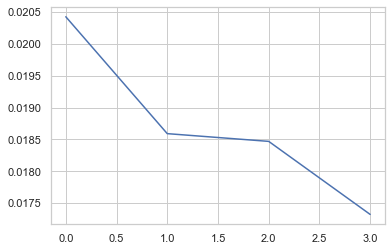

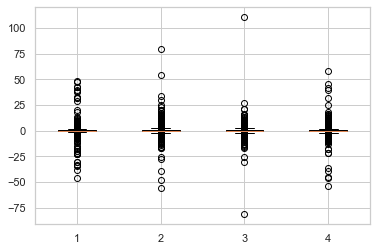

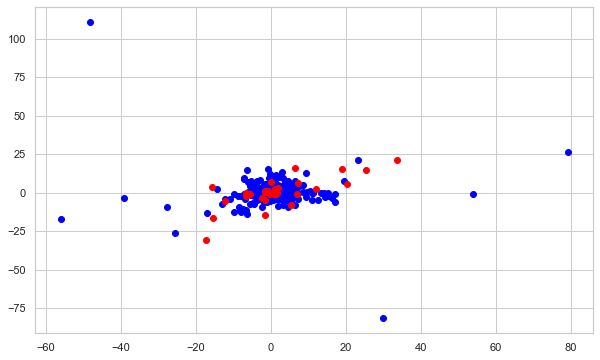

In [27]:
pca = sd.PCA(n_components=4)
scaler = sp.scale(Coeff_rawdata[:,:1024])
acp = pca.fit_transform(scaler)
plt.plot(pca.explained_variance_ratio_)
plt.show()
plt.boxplot(acp)
plt.show()
plt.figure(figsize=(10,6))
plt.scatter(acp[listinliers,1], acp[listinliers,2],color="blue")
plt.scatter(acp[listoutliers,1], acp[listoutliers,2],color="red")
#plt.xlim(-limx,limx)
#plt.ylim(-limy,limy)
plt.show()

In [29]:
anoSVM,anoLOF,anoISO=detection_anomaly(Coeff[listinliers,:1024],Coeff[1677:,:1024])

C:\Users\sebas\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


nombre d'anomalies trouvées par SVM 261
nombre d'anomalies trouvées par LOF 322
nombre d'anomalies trouvées par Isolation Forest 296
scores Isolation Forest
f1score : 0.6062717770034843  ; precision :  0.5878378378378378  ; recall :  0.6258992805755396
scores SVM
f1score : 0.953617810760668  ; precision :  0.9846743295019157  ; recall :  0.9244604316546763
scores LOF
f1score : 0.77  ; precision :  0.717391304347826  ; recall :  0.8309352517985612
scores union des techniques
f1score : 0.7561327561327561  ; precision :  0.6313253012048192  ; recall :  0.9424460431654677
scores intersection des techniques
f1score : 0.8994082840236687  ; precision :  0.9956331877729258  ; recall :  0.8201438848920863
scores intersection SVM LOF
f1score : 0.8994082840236687  ; precision :  0.9956331877729258  ; recall :  0.8201438848920863
scores intersection Isolation Forest LOF
f1score : 0.5945945945945946  ; precision :  0.7044334975369458  ; recall :  0.5143884892086331
scores intersection SVM Isolation

### VAE

In [30]:
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku

import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

In [31]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon


In [33]:
batch_size=100
intermediate_dim = 512
latent_dim = 2
epochs = 2


In [37]:
z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [38]:
# instantiate encoder model

encoder = km.Model(inputs, z, name='encoder')
encoder.summary()
#ku.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          524800      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_6[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_6[0][0]                    
____________________________________________________________________________________________

In [41]:
# %load solutions/decoder_vae.py
# build decoder model
latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(1024, activation='sigmoid')(x)

# instantiate decoder model
decoder = km.Model(latent_inputs, outputs, name='decoder')

In [42]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              525312    
Total params: 526,848
Trainable params: 526,848
Non-trainable params: 0
_________________________________________________________________


In [43]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = km.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 1024)]            0         
_________________________________________________________________
encoder (Model)              (100, 2)                  526852    
_________________________________________________________________
decoder (Model)              multiple                  526848    
Total params: 1,053,700
Trainable params: 1,053,700
Non-trainable params: 0
_________________________________________________________________


In [45]:
reconstruction_loss = kloss.binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [60]:
vae.fit(Coeff[:1300,:1024],epochs=5,verbose=True, batch_size=batch_size,use_multiprocessing=True)

Train on 1300 samples
Epoch 1/5
1300/1300 [==============================] - 0s 245us/sample - loss: -313.1605
Epoch 2/5
1300/1300 [==============================] - 0s 252us/sample - loss: -329.5684
Epoch 3/5
1300/1300 [==============================] - 0s 237us/sample - loss: -337.7395
Epoch 4/5
1300/1300 [==============================] - 0s 247us/sample - loss: -349.4649
Epoch 5/5
1300/1300 [==============================] - 0s 232us/sample - loss: -361.9095


In [62]:
vae_ad.fit(Coeff[:1300,:1024],epochs=5, batch_size=batch_size, )

Train on 1300 samples
Epoch 1/5
1300/1300 [==============================] - 2s 1ms/sample - loss: 1295.4525
Epoch 2/5
1300/1300 [==============================] - 0s 235us/sample - loss: 415.7099
Epoch 3/5
1300/1300 [==============================] - 0s 245us/sample - loss: 184.4477
Epoch 4/5
1300/1300 [==============================] - 0s 251us/sample - loss: 54.8851
Epoch 5/5
1300/1300 [==============================] - 0s 243us/sample - loss: -16.0670


In [63]:
x_test_decoded_vae = vae_ad.predict(Coeff[1677:,:1024], batch_size=batch_size)

InvalidArgumentError:  Incompatible shapes: [94,2] vs. [100,2]
	 [[node vae_mlp/encoder/z/mul (defined at C:\Users\sebas\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_5663]

Function call stack:
distributed_function


In [171]:
import keras.backend as K
def wasserstein ( ytrue , ypred ):
    return K.mean(ytrue * ypred)

ModuleNotFoundError: No module named 'keras'

In [ ]:
optimizerG = RMSprop( lr =0.00005)
optimizerD = RMSprop ( lr =0.00005)